##MLEM reconstruction using CNN

##Imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage.data import brain
from skimage.transform import resize, radon, iradon
from skimage.metrics import mean_squared_error, structural_similarity
from IPython.display import display, clear_output

##Load true image

In [ ]:
plt.ion()
brainimage = brain()

# Dimensions of image
nxd = 128

true_object_np = resize(brainimage[9, 30: -1, : -30], (nxd, nxd), anti_aliasing=False)


##Define functions

In [ ]:
# Number of viewing angles in the sinogram
nphi = int(nxd * 1.42)

# Number of pixels in the radial dimension
nrd = int(nxd * 1.42)



# System matrix as a torch tensor
def make_torch_system_matrix(nxd, nrd, nphi):
    system_matrix = torch.zeros(nrd * nphi, nxd * nxd)  # Rows = num of sinogram bins, Cols = num of image pixels
    for xv in range(nxd):
        for yv in range(nxd):   #selext pixel with coordinates (xv, yv)
            for ph in range(nphi):  # For each angle, the pixel is projected
                yp = -(xv - (nxd * 0.5)) * np.sin(ph * np.pi / nphi) + (yv - (nxd * 0.5)) * np.cos(ph * np.pi / nphi)
                yp_bin = int(yp + nrd / 2.0)  # We find where each pixel lands on the sinogram and build the system matrix
                system_matrix[yp_bin + ph * nrd, xv + yv * nxd] = 1.0
    return system_matrix

# Convert torch tensors to numpy arrays
def torch_to_np(torch_array):
    return np.squeeze(torch_array.detach().cpu().numpy())

# Convert numpy arrays to torch tensors
def np_to_00torch(np_array):
    return torch.from_numpy(np_array).float().unsqueeze(0).unsqueeze(0)
#2 extra dimensions added for the tensor to be compatible with the nn

# Forward project the image using the system matrix
def fp_system_torch(image, sys_mat, nxd, nrd, nphi):
    return torch.reshape(torch.mm(sys_mat, torch.reshape(image, (nxd * nxd, 1))), (nphi, nrd))

# Back project the sinogram to obtain an image
def bp_system_torch(sino, sys_mat, nxd, nrd, nphi):
    return torch.reshape(torch.mm(sys_mat.T, torch.reshape(sino, (nrd * nphi, 1))), (nxd, nxd))

##Create system matrix and measured sinogram as torch tensors

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Check if a GPU is available, otherwise use CPU

sys_mat = make_torch_system_matrix(nxd, nrd, nphi).to(device)  # System matrix for forward and back projection
true_object_torch = np_to_00torch(true_object_np).to(device)  # Convert the object into a torch tensor
true_sinogram_torch = fp_system_torch(true_object_torch, sys_mat, nxd, nrd, nphi)  # Forward project the torch tensor to obtain a true sinogram


##Define CNN architecture

In [ ]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.CNN = nn.Sequential(
            nn.Conv2d(1, 8, 7, padding= (3,3)), nn.PReLU(), #1 input image, 8 channels, 7x7 kernels
            nn.Conv2d(8, 8, 7, padding= (3,3)), nn.PReLU(),
            nn.Conv2d(8, 8, 7, padding= (3,3)), nn.PReLU(),
            nn.Conv2d(8, 8, 7, padding= (3,3)), nn.PReLU(),
            nn.Conv2d(8, 1, 7, padding= (3,3)), nn.PReLU(),
        )

    def forward(self, x):
      x = torch.squeeze(self.CNN(x.unsqueeze(0).unsqueeze(0)))
      return torch_to_np(x)

##Define class for DL MLEM reconstruction

In [ ]:
class MLEM_CNN_Net(nn.Module): #torch.nn = base class for all PyTorch nn modules
    def __init__(self, cnn, sino_for_reconstruction, num_its):
      super(MLEM_CNN_Net, self).__init__() #inherit attributes and methods from the base class, torch.nn
      self.num_its = num_its
      self.sino_ones = torch.ones_like(sino_for_reconstruction)
      self.sens_image = bp_system_torch(self.sino_ones, sys_mat, nxd, nrd, nphi)
      self.cnn = cnn
      self.recon = torch.ones(nxd,nxd).to(device)

    def forward(self, sino_for_reconstruction):
      for it in range(self.num_its):
        fpsino = fp_system_torch(self.recon, sys_mat, nxd, nrd, nphi)
        ratio = sino_for_reconstruction / (fpsino + 1.0e-6)
        correction = bp_system_torch(ratio, sys_mat, nxd, nrd, nphi) / (self.sens_image + 1.0e-6)
        self.recon = self.recon * correction
        #INTER UPDATE CNN -> cnn processes reconstructed image further to improve quality
        self.recon = torch.abs (self.recon + self.cnn(self.recon))


      axs[1, 0].imshow(torch_to_np(self.recon), cmap='Greys_r')
      axs[1, 0].set_title('MLEM reconstruction')

      axs[1, 1].imshow(fpsino, cmap='Greys_r')
      axs[1, 1].set_title('FP of recon')

      axs[0, 2].imshow(ratio, cmap='Greys_r')
      axs[0, 2].set_title('Ratio Sinogram')

      axs[1, 2].imshow(correction, cmap='Greys_r')
      axs[1, 2].set_title('BP of ratio')

      display(fig)
      clear_output(wait=True)
      plt.pause(0.5)
      return self.recon


##Training the network

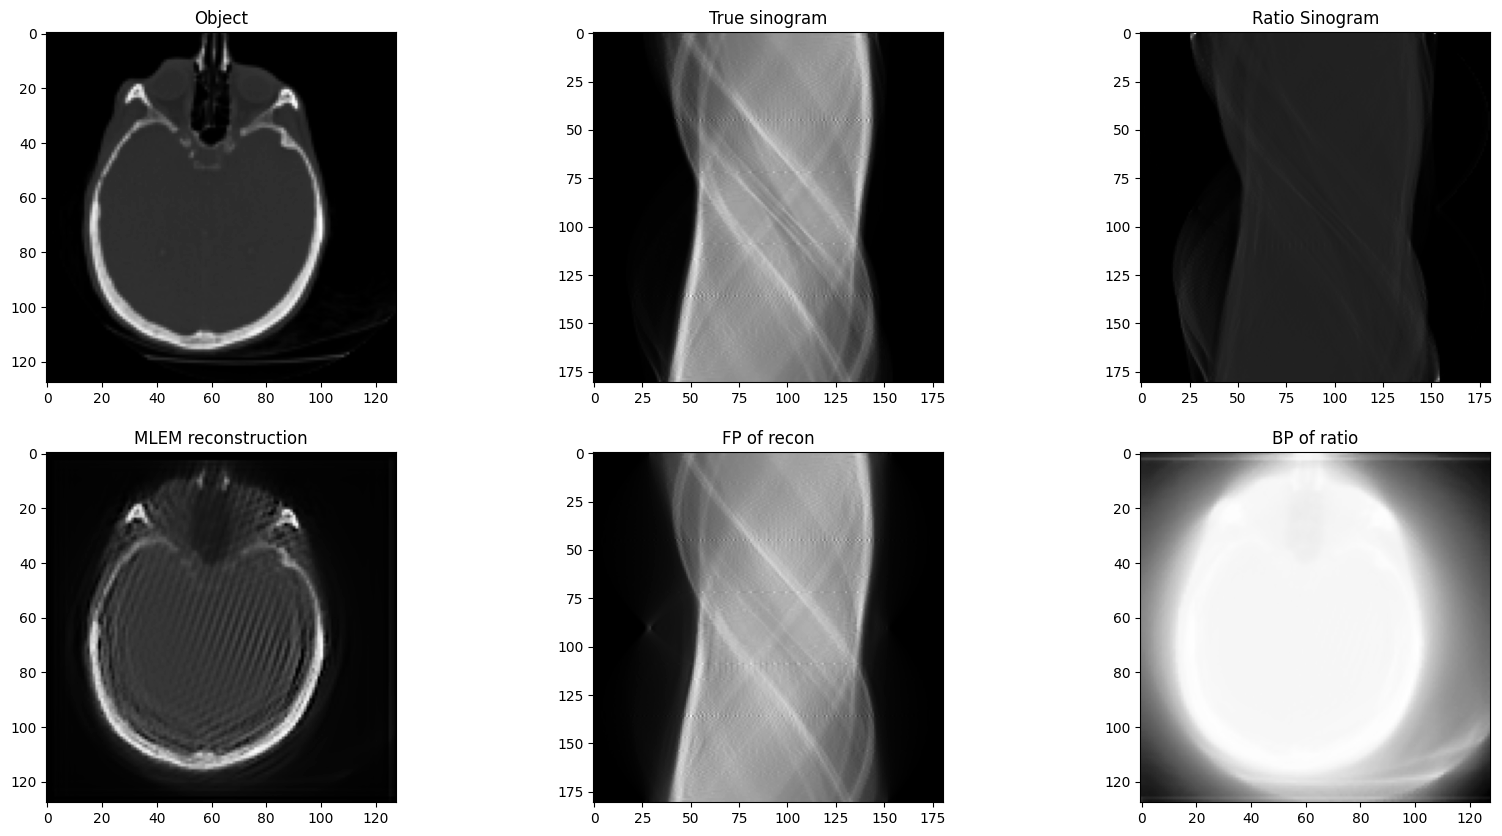

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs[0, 0].imshow(true_object_np, cmap='Greys_r')
axs[0, 0].set_title('Object')

axs[0, 1].imshow(torch_to_np(true_sinogram_torch), cmap='Greys_r')
axs[0, 1].set_title('True sinogram')

import torch
import torch.nn as nn
import torch.optim as optim
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr

def calculate_mae(output, target):
    return torch.abs(output - target).mean().item()

def calculate_ssim(output, target):
    output = output.cpu().detach().numpy().squeeze()
    target = target.cpu().detach().numpy().squeeze()
    return ssim(output, target, data_range=output.max() - output.min())

def calculate_cc(output, target):
    output = output.cpu().detach().numpy().squeeze()
    target = target.cpu().detach().numpy().squeeze()
    return pearsonr(output.flatten(), target.flatten())[0]

def calculate_convergence(output, target):
    return torch.mean(torch.abs(output - target)).item()


core_iterations = 5
cnn = CNN().to(device)  # Assuming CNN accepts 32 channels
cnnmlem = MLEM_CNN_Net(cnn, true_sinogram_torch, core_iterations).to(device)

loss_fun = nn.MSELoss()
optimiser = torch.optim.Adam(cnnmlem.parameters(), lr=1e-6)

train_loss = []
train_mae = []
train_ssim = []
train_cc = []
train_convergence = []

epochs = 50

for ep in range(epochs):
    rec_out = cnnmlem(true_sinogram_torch)
    loss = loss_fun(rec_out, torch.squeeze(true_object_torch))
    loss.requires_grad = True

    # Calculate metrics
    mae = calculate_mae(rec_out, true_object_torch)
    ssim_val = calculate_ssim(rec_out, true_object_torch)
    cc_val = calculate_cc(rec_out, true_object_torch)

    #print(f"Epoch {ep+1}/{epochs}, Loss: {loss.item():.6f}, MAE: {mae:.6f}, SSIM: {ssim_val:.6f}, CC: {cc_val:.6f}")

    # Store metrics
    train_loss.append(loss.item())
    train_mae.append(mae)
    train_ssim.append(ssim_val)
    train_cc.append(cc_val)

    # Backpropagation
    loss.backward()
    optimiser.step()
    optimiser.zero_grad()





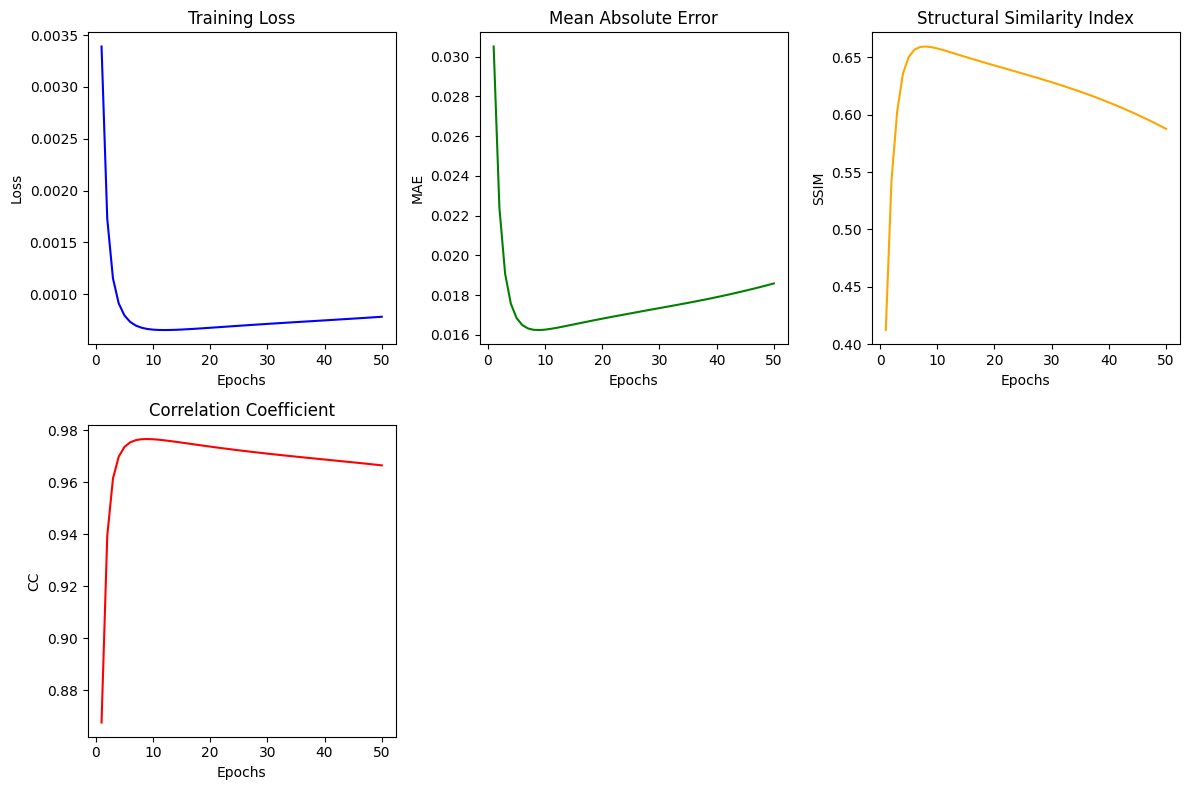

In [ ]:
import matplotlib.pyplot as plt

# Plotting
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 8))

# Plotting loss
plt.subplot(2, 3, 1)
plt.plot(epochs_range, train_loss, label='Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

# Plotting MAE
plt.subplot(2, 3, 2)
plt.plot(epochs_range, train_mae, label='MAE', color='green')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Mean Absolute Error')

# Plotting SSIM
plt.subplot(2, 3, 3)
plt.plot(epochs_range, train_ssim, label='SSIM', color='orange')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.title('Structural Similarity Index')

# Plotting CC
plt.subplot(2, 3, 4)
plt.plot(epochs_range, train_cc, label='CC', color='red')
plt.xlabel('Epochs')
plt.ylabel('CC')
plt.title('Correlation Coefficient')

plt.tight_layout()
plt.show()


In [ ]:
import csv

csv_filename = "metrics.csv"

headers = ["Epoch", "Loss", "MAE", "SSIM", "CC"]

all_metrics = zip(epochs_range, train_loss, train_mae, train_ssim, train_cc)

with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(headers)

    for row in all_metrics:
        writer.writerow(row)

print("Metrics saved to", csv_filename)


Metrics saved to metrics.csv
